In [1]:
from mira.openai import OpenAIClient
from mira.sources.sympy_ode.llm_util import execute_template_model_from_sympy_odes, image_file_to_odes_str
client = OpenAIClient()

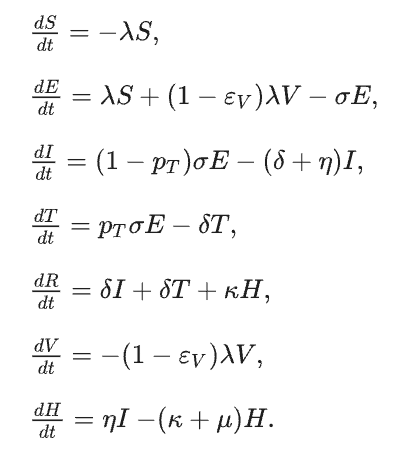

In [2]:
# Extract ODEs from image
from IPython.display import Image
Image('images/odes_to_mira_SEVITHR.png')

In [3]:
ode_str = image_file_to_odes_str('images/odes_to_mira_SEVITHR.png', client=client)
print(ode_str)
# Note that the LLM sometimes misses to define one of the parameters. When this happens, a human-in-the-loop can quickly edit the output

import sympy

# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S, E, I, T, R, V, H = sympy.symbols("S E I T R V H", cls=sympy.Function)

# Define the parameters
lambda_, epsilon_v, sigma, p_T, delta, eta, kappa, mu = sympy.symbols("lambda epsilon_v sigma p_T delta eta kappa mu")

odes = [
    sympy.Eq(S(t).diff(t), -lambda_ * S(t)),
    sympy.Eq(E(t).diff(t), lambda_ * S(t) + (1 - epsilon_v) * lambda_ * V(t) - sigma * E(t)),
    sympy.Eq(I(t).diff(t), (1 - p_T) * sigma * E(t) - (delta + eta) * I(t)),
    sympy.Eq(T(t).diff(t), p_T * sigma * E(t) - delta * T(t)),
    sympy.Eq(R(t).diff(t), delta * I(t) + delta * T(t) + kappa * H(t)),
    sympy.Eq(V(t).diff(t), -(1 - epsilon_v) * lambda_ * V(t)),
    sympy.Eq(H(t).diff(t), eta * I(t) - (kappa + mu) * H(t))
]


In [4]:
# Cleaned version of string above, uncomment to use it
# ode_str = """import sympy

# # Define time variable
# t = sympy.symbols("t")

# # Define the time-dependent variables
# S, E, I, T, R, V, H = sympy.symbols("S E I T R V H", cls=sympy.Function)

# # Define the parameters
# lambda_, epsilon_v, p_T, delta, eta, kappa, mu, sigma = sympy.symbols("lambda_ epsilon_v p_T delta eta kappa mu sigma")

# odes = [
#     sympy.Eq(S(t).diff(t), - lambda_ * S(t)),
#     sympy.Eq(E(t).diff(t), lambda_ * S(t) + (1 - epsilon_v) * lambda_ * V(t) - sigma * E(t)),
#     sympy.Eq(I(t).diff(t), (1 - p_T) * sigma * E(t) - (delta + eta) * I(t)),
#     sympy.Eq(T(t).diff(t), p_T * sigma * E(t) - delta * T(t)),
#     sympy.Eq(R(t).diff(t), delta * I(t) + delta * T(t) + kappa * H(t)),
#     sympy.Eq(V(t).diff(t), - (1 - epsilon_v) * lambda_ * V(t)),
#     sympy.Eq(H(t).diff(t), eta * I(t) - (kappa + mu) * H(t))
# ]"""

In [5]:
# Now get a template model from the extracted ODE str and send the ODE system in for attempting to ground each compartment
tm = execute_template_model_from_sympy_odes(ode_str=ode_str, attempt_grounding=True, client=client)

In [6]:
# Check the concepts
print('concept name\tidentifiers\tcontext')
for concept in tm.get_concepts_map().values():
    print(f'{concept.name}\t{concept.identifiers}\t{concept.context}')

concept name	identifiers	context
S	{'ido': '0000514'}	{'species': 'ncbitaxon:9606', 'status': 'susceptible'}
E	{'apollosv': '00000154'}	{'species': 'ncbitaxon:9606', 'stage': 'exposed'}
V	{'ido': '0000514'}	{'species': 'ncbitaxon:9606', 'status': 'vaccinated'}
I	{'ido': '0000511'}	{'species': 'ncbitaxon:9606', 'infectivity': 'infected'}
T	{'ido': '0000511'}	{'species': 'ncbitaxon:9606', 'status': 'treatment'}
R	{'ido': '0000592'}	{'species': 'ncbitaxon:9606', 'status': 'recovered'}
H	{'ido': '0000511'}	{'species': 'ncbitaxon:9606', 'hospitalization': 'ncit:C25179'}


In [7]:
from mira.modeling import Model
from mira.modeling.ode import OdeModel
om = OdeModel(Model(tm), initialized=True)
om.get_interpretable_kinetics()

Matrix([
[Derivative(S, t), =,                                      -S*lambda],
[Derivative(E, t), =, -E*sigma + S*lambda + V*lambda*(1 - epsilon_v)],
[Derivative(V, t), =,                      -V*lambda*(1 - epsilon_v)],
[Derivative(I, t), =,            E*sigma*(1 - p_T) - I*(delta + eta)],
[Derivative(T, t), =,                          E*p_T*sigma - T*delta],
[Derivative(R, t), =,                    H*kappa + I*delta + T*delta],
[Derivative(H, t), =,                        -H*(kappa + mu) + I*eta]])